In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

In [2]:
def get_response_times_with_default(sessionfile):
    response_times_in_trial = (sessionfile.trials.response-sessionfile.trials.starts)
    default_response_time = np.nanmedian(response_times_in_trial)

    response_times = sessionfile.trials.response
    nogo_trials = np.isnan(response_times)
    response_times[nogo_trials] = sessionfile.trials.starts[nogo_trials]+default_response_time
    return response_times

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Revisions\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shoul

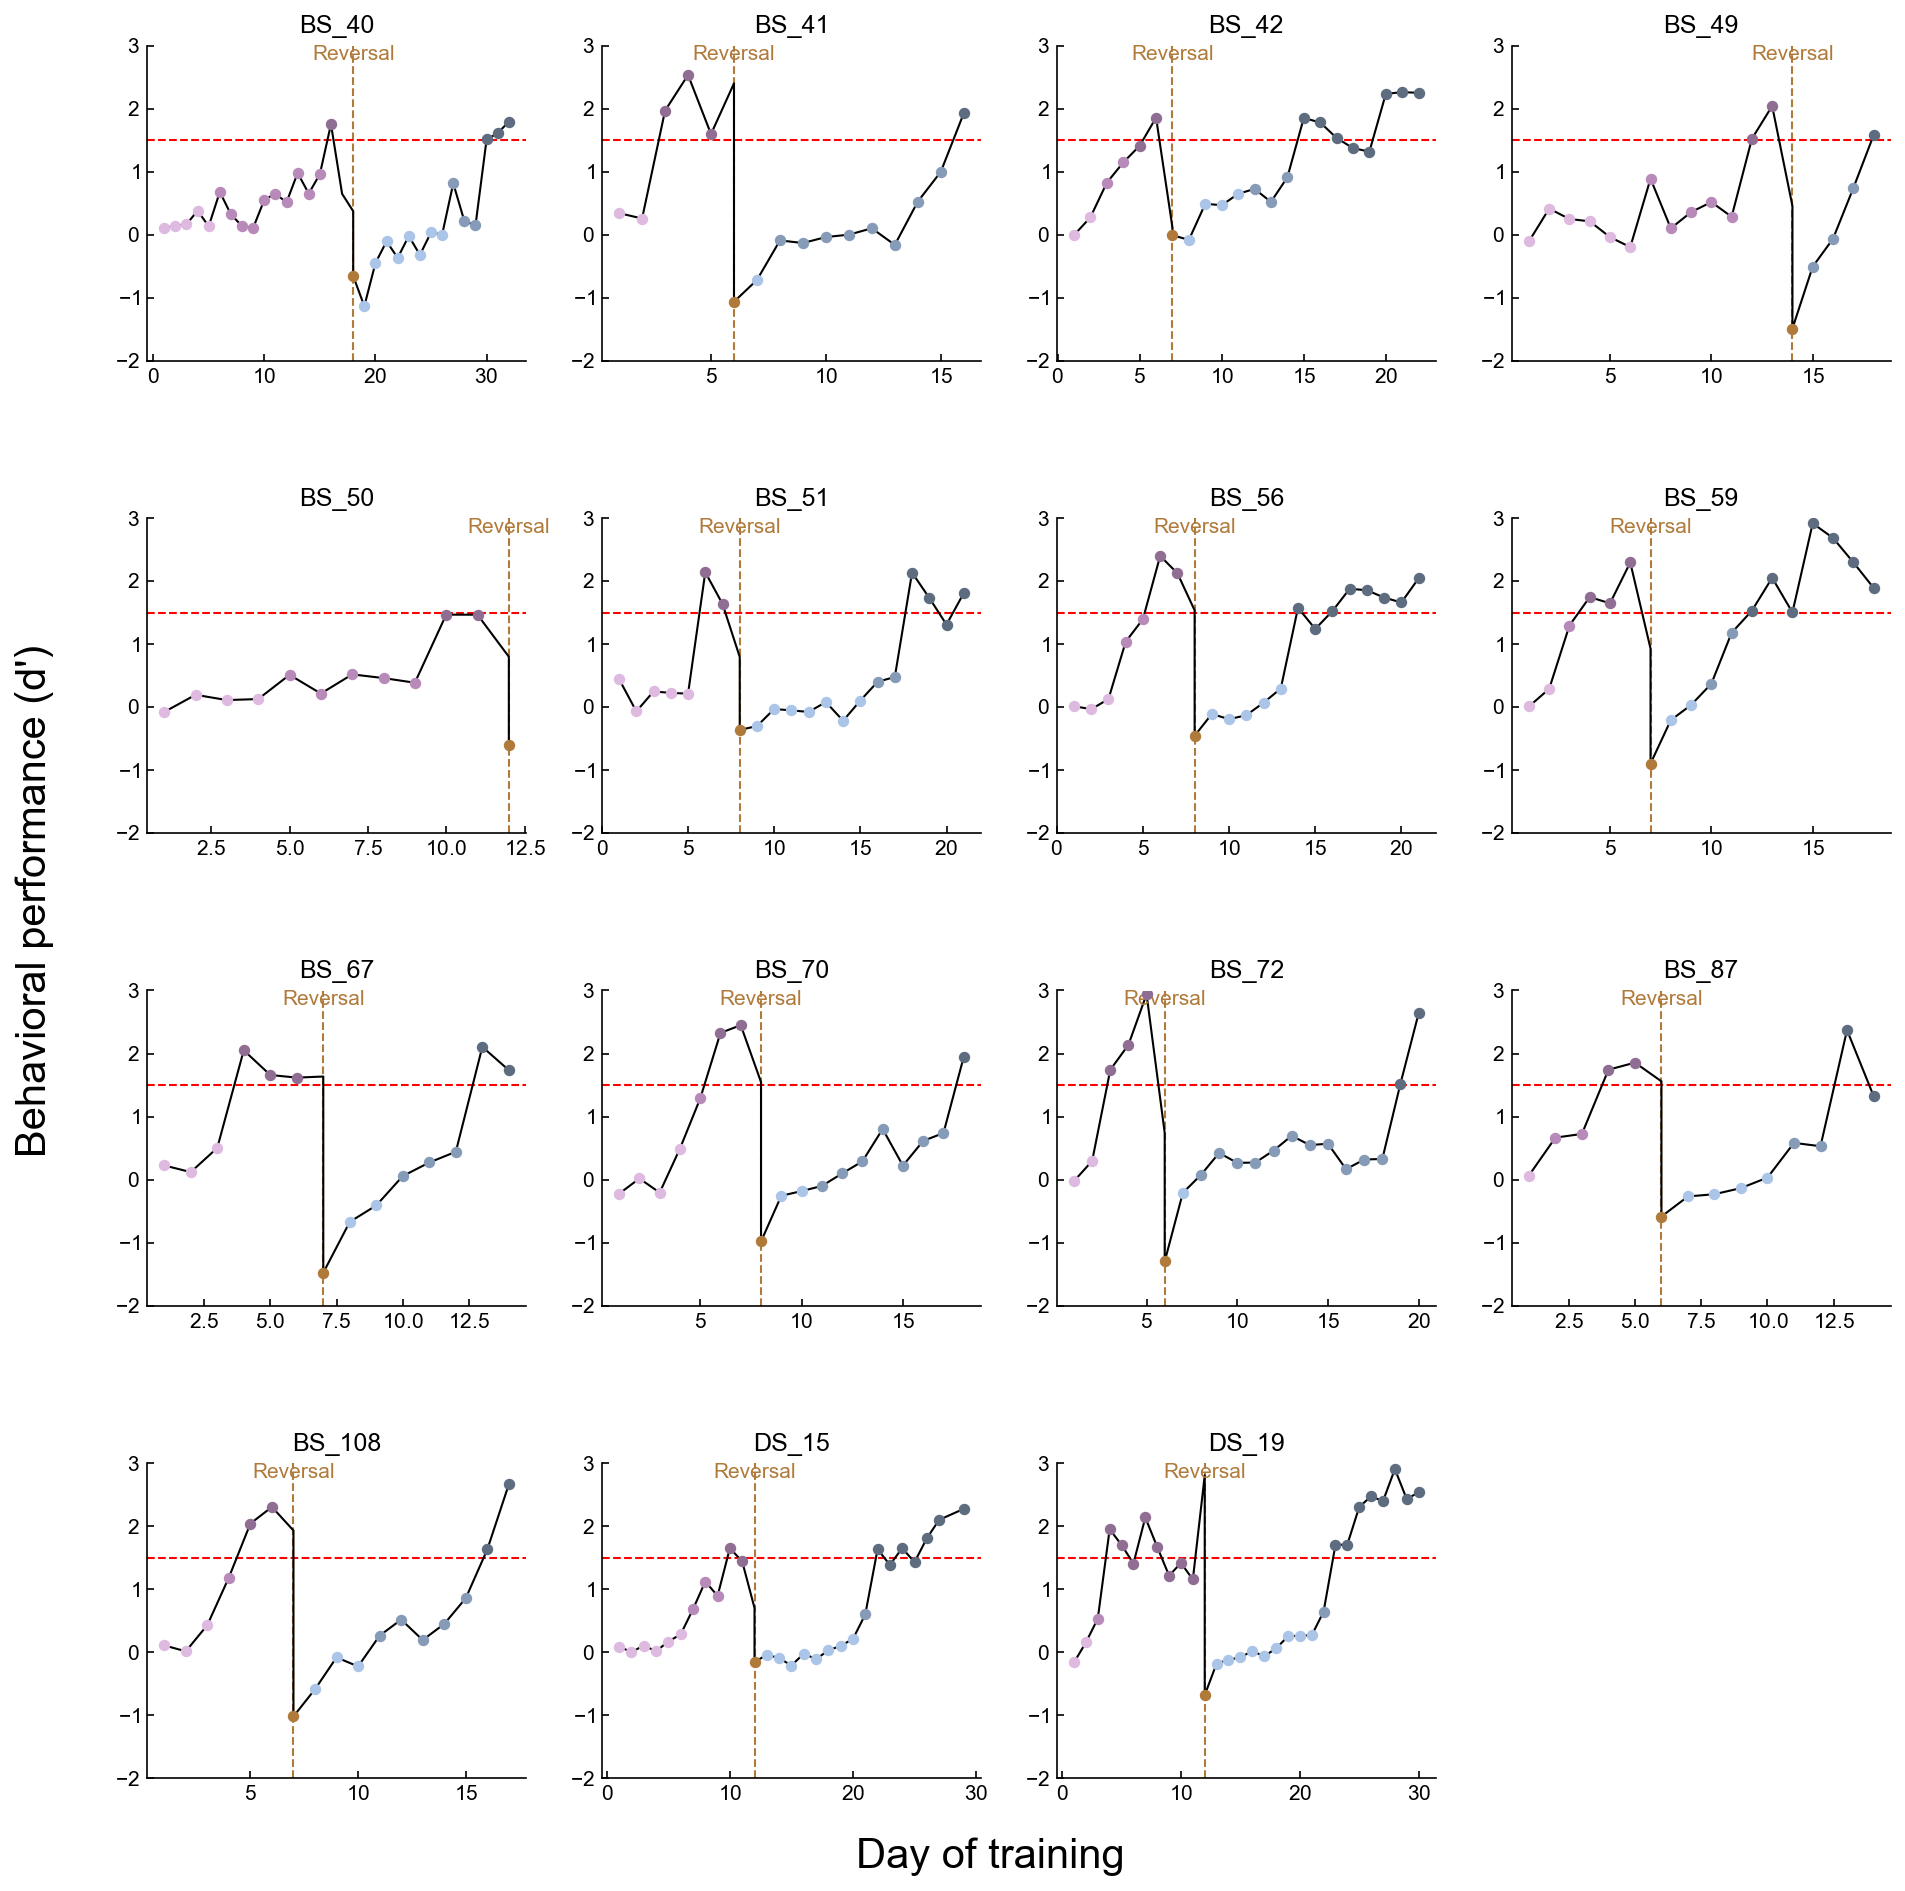

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(dualanimalnames,animalBehaviors,plot=True)

In [5]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task == 'passive no behavior':
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    
    if sessionfile.meta.animal not in dualanimalnames:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:12<00:00, 61.15it/s] 


In [6]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
        raise e
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:50<00:00, 35.90it/s]

errors for: []


In [7]:
animal_list = []
session_list = []
cluster_list = []
learning_phase_list = []
go_FR_list = []
nogo_FR_list = []
pval_gonogo_list = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    response_times = get_response_times_with_default(sessionfile)
    response_times = sessionfile.trials.response
    allConditions = ilep.getAllConditions(sessionfile,clust)

    ### Extract spike times
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    goTrialSpikes = []
    nogoTrialSpikes = []
    for trial in allConditions['go'].trials:
        # starttime = sessionfile.trials.starts[trial]
        # endtime = sessionfile.trials.starts[trial]+50*sessionfile.meta.fs/1000
        # this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        starttime = response_times[trial]-50*sessionfile.meta.fs/1000
        endtime = response_times[trial]
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_FR = len(this_trial_spikes) / 0.05
        goTrialSpikes.append(this_trial_FR)
    for trial in allConditions['nogo'].trials:
        starttime = response_times[trial]-50*sessionfile.meta.fs/1000
        endtime = response_times[trial]
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_FR = len(this_trial_spikes) / 0.05
        nogoTrialSpikes.append(this_trial_FR)

    animal_list.append(sessionfile.meta.animal)
    session_list.append(session)
    cluster_list.append(clust)
    learning_phase_list.append(EILphases[idx])
    go_FR_list.append(np.mean(goTrialSpikes))
    nogo_FR_list.append(np.mean(nogoTrialSpikes))
    pval_gonogo_list.append(ttest_ind(goTrialSpikes,nogoTrialSpikes).pvalue)

7it [00:01,  6.54it/s]C:\Users\4thgr\AppData\Local\anaconda3\envs\TothSidleckEnv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\4thgr\AppData\Local\anaconda3\envs\TothSidleckEnv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
870it [05:10,  4.78it/s]

session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved ac

871it [05:10,  3.75it/s]

session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22


872it [05:11,  4.23it/s]

session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to lo

1829it [09:45,  3.12it/s]


In [8]:
df_dict = dict()
df_dict['animal'] = animal_list
df_dict['session'] = session_list
df_dict['cluster'] = cluster_list
df_dict['learning phase'] = learning_phase_list
df_dict['go firing rate'] = go_FR_list
df_dict['nogo firing rate'] = nogo_FR_list
df_dict['go nogo significance'] = pval_gonogo_list
df = pd.DataFrame(df_dict)

In [9]:
df

,animal,session,cluster,learning phase,go firing rate,nogo firing rate,go nogo significance
0,BS_108,BS_108_1_AC.pickle,2,pre expert,6.363636,6.060606,0.916963
1,BS_108,BS_108_1_AC.pickle,8,pre expert,9.213483,17.714286,0.014307
2,BS_108,BS_108_1_AC.pickle,9,pre expert,24.269663,7.428571,0.000279
3,BS_108,BS_108_1_AC.pickle,14,pre expert,5.227273,2.424242,0.294047
4,BS_108,BS_108_1_AC.pickle,34,pre expert,12.359551,6.857143,0.154290
...,...,...,...,...,...,...,...
1824,DS_19,DS_19_9_AC.pickle,53,post early,12.693727,3.333333,0.006201
1825,DS_19,DS_19_9_AC.pickle,56,post early,3.386243,3.971631,0.384140
1826,DS_19,DS_19_9_AC.pickle,57,post early,3.469388,0.000000,0.592552
1827,DS_19,DS_19_9_AC.pickle,62,post early,2.074689,0.000000,0.624907


In [10]:
FR_go_preearly = []
FR_go_prelate = []
FR_go_preexpert = []
FR_go_postearly = []
FR_go_postlate = []
FR_go_postexpert = []

FR_nogo_preearly = []
FR_nogo_prelate = []
FR_nogo_preexpert = []
FR_nogo_postearly = []
FR_nogo_postlate = []
FR_nogo_postexpert = []

for row in df.iloc:
    if row['learning phase'] == 'pre early':
        FR_go_preearly.append(row['go firing rate'])
        FR_nogo_preearly.append(row['nogo firing rate'])
    if row['learning phase'] == 'pre late':
        FR_go_prelate.append(row['go firing rate'])
        FR_nogo_prelate.append(row['nogo firing rate'])
    if row['learning phase'] == 'pre expert':
        FR_go_preexpert.append(row['go firing rate'])
        FR_nogo_preexpert.append(row['nogo firing rate'])
        
    if row['learning phase'] == 'post early':
        FR_go_postearly.append(row['go firing rate'])
        FR_nogo_postearly.append(row['nogo firing rate'])
    if row['learning phase'] == 'post late':
        FR_go_postlate.append(row['go firing rate'])
        FR_nogo_postlate.append(row['nogo firing rate'])
    if row['learning phase'] == 'post expert':
        FR_go_postexpert.append(row['go firing rate'])
        FR_nogo_postexpert.append(row['nogo firing rate'])

FR_go_preearly = np.array(FR_go_preearly)
FR_go_prelate = np.array(FR_go_prelate)
FR_go_preexpert = np.array(FR_go_preexpert)
FR_go_postearly = np.array(FR_go_postearly)
FR_go_postlate = np.array(FR_go_postlate)
FR_go_postexpert = np.array(FR_go_postexpert)

FR_nogo_preearly = np.array(FR_nogo_preearly)
FR_nogo_prelate = np.array(FR_nogo_prelate)
FR_nogo_preexpert = np.array(FR_nogo_preexpert)
FR_nogo_postearly = np.array(FR_nogo_postearly)
FR_nogo_postlate = np.array(FR_nogo_postlate)
FR_nogo_postexpert = np.array(FR_nogo_postexpert)

In [11]:
stdfont = 14
stdyfrac = 0.06

C:\Users\4thgr\AppData\Local\Temp\ipykernel_44172\3643454862.py:37: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data_nogo)),width=0.25,minjitter=0.075)
C:\Users\4thgr\AppData\Local\Temp\ipykernel_44172\3643454862.py:43: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data_go)),width=0.25,minjitter=0.075)


NameError: name 'current_version' is not defined

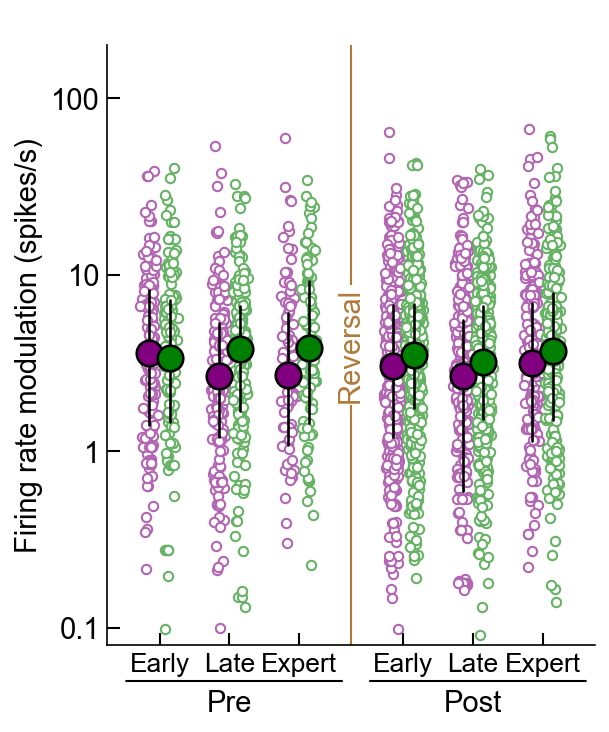

In [12]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
    
FRmod_baseline_median = 3.5
data_go = [FR_go_preearly,FR_go_prelate,FR_go_preexpert,FR_go_postearly,FR_go_postlate,FR_go_postexpert]
data_nogo = [FR_nogo_preearly,FR_nogo_prelate,FR_nogo_preexpert,FR_nogo_postearly,FR_nogo_postlate,FR_nogo_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = 6

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data_nogo,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data_nogo),width=0.25,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data_nogo)),width=0.25,minjitter=0.075)
X = np.array(X) - 0.15
ax.scatter(X, Y, s=size, ec='purple', fc='white', lw=1,zorder=-10,clip_on=False)
###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data_go,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data_go),width=0.25,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data_go)),width=0.25,minjitter=0.075)
X = np.array(X) + 0.15
ax.scatter(X, Y, s=size, ec='green', fc='white', lw=1,zorder=-10,clip_on=False)


ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data_nogo,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    eye_color= 'purple'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    ax.scatter([idx+polarity*switch_offset-0.15], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset-0.15, idx+polarity*switch_offset-0.15], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')#Plot summary

for idx,(column,polarity) in enumerate(zip(data_go,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    eye_color= 'green'#NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    ax.scatter([idx+polarity*switch_offset+0.15], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset+0.15, idx+polarity*switch_offset+0.15], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.08,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Choice Go Nogo Summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [ ]:
print(normaltest(ilep.rmnan(FR_go_preearly)))
print(normaltest(ilep.rmnan(FR_go_prelate)))
print(normaltest(ilep.rmnan(FR_go_preexpert)))
print(normaltest(ilep.rmnan(FR_go_postearly)))
print(normaltest(ilep.rmnan(FR_go_postlate)))
print(normaltest(ilep.rmnan(FR_go_postexpert)))

print(normaltest(ilep.rmnan(FR_nogo_preearly)))
print(normaltest(ilep.rmnan(FR_nogo_prelate)))
print(normaltest(ilep.rmnan(FR_nogo_preexpert)))
print(normaltest(ilep.rmnan(FR_nogo_postearly)))
print(normaltest(ilep.rmnan(FR_nogo_postlate)))
print(normaltest(ilep.rmnan(FR_nogo_postexpert)))

In [ ]:
data_go = SimpleNamespace()
data_go.preearly = np.abs(FR_go_preearly)
data_go.prelate = np.abs(FR_go_prelate)
data_go.preexpert = np.abs(FR_go_preexpert)
data_go.postearly = np.abs(FR_go_postearly)
data_go.postlate = np.abs(FR_go_postlate)
data_go.postexpert = np.abs(FR_go_postexpert)

data_nogo = SimpleNamespace()
data_nogo.preearly = np.abs(FR_nogo_preearly)
data_nogo.prelate = np.abs(FR_nogo_prelate)
data_nogo.preexpert = np.abs(FR_nogo_preexpert)
data_nogo.postearly = np.abs(FR_nogo_postearly)
data_nogo.postlate = np.abs(FR_nogo_postlate)
data_nogo.postexpert = np.abs(FR_nogo_postexpert)

ilep.nonparametricIndependentStatsCompareToOther(data_go,data_nogo)
pass

In [ ]:
sig_preearly = np.less(df[df['learning phase'] == 'pre early']['go nogo significance'],0.05)
sig_prelate = np.less(df[df['learning phase'] == 'pre late']['go nogo significance'],0.05)
sig_preexpert = np.less(df[df['learning phase'] == 'pre expert']['go nogo significance'],0.05)
sig_postearly = np.less(df[df['learning phase'] == 'post early']['go nogo significance'],0.05)
sig_postlate = np.less(df[df['learning phase'] == 'post late']['go nogo significance'],0.05)
sig_postexpert = np.less(df[df['learning phase'] == 'post expert']['go nogo significance'],0.05)

print(f"pre early: {np.sum(sig_preearly)} cells are significantly modulated")
print(f"pre late: {np.sum(sig_prelate)} cells are significantly modulated")
print(f"pre expert: {np.sum(sig_preexpert)} cells are significantly modulated")
print(f"post early: {np.sum(sig_postearly)} cells are significantly modulated")
print(f"post late: {np.sum(sig_postlate)} cells are significantly modulated")
print(f"post expert: {np.sum(sig_postexpert)} cells are significantly modulated")
print()
print(f"pre early: {100*np.mean(sig_preearly)}% of cells are significantly modulated")
print(f"pre late {100*np.mean(sig_prelate)}% of cells are significantly modulated")
print(f"pre expert {100*np.mean(sig_preexpert)}% of cells are significantly modulated")
print(f"post early {100*np.mean(sig_postearly)}% of cells are significantly modulated")
print(f"post late {100*np.mean(sig_postlate)}% of cells are significantly modulated")
print(f"post expert {100*np.mean(sig_postexpert)}% of cells are significantly modulated")